In [56]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [23]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
sample_submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
sample_submission.head(), train.shape, test.shape

(  PassengerId  Transported
 0     0013_01        False
 1     0018_01        False
 2     0019_01        False
 3     0021_01        False
 4     0023_01        False,
 (8693, 14),
 (4277, 13))

In [24]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [25]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [27]:
train = train.drop(['Name', 'PassengerId', 'Cabin'], axis=1)

In [28]:
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
# label = ['Transported']

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
ssi = SimpleImputer(strategy = 'most_frequent')
knni = KNNImputer(n_neighbors = 7)
train[cat_cols] = ssi.fit_transform(train[cat_cols])
train[num_cols] = knni.fit_transform(train[num_cols])
train.isna().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

In [29]:
y = train['Transported']
X = train.drop(columns = ['Transported'],axis=1)


In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
num_pipeline = Pipeline([('std_scalar', Normalizer())])
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelBinarizer

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# onehot encode
ohe = OneHotEncoder(sparse=False,handle_unknown="ignore")

# #Binary encode
# lb = LabelBinarizer()
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(transformers=[('num', num_pipeline, num_cols),
                        ('ohe', ohe, cat_cols)])

In [31]:
X = ct.fit_transform(X)
y=np.where(y == True, 1, 0)

In [32]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2,random_state = 42)

In [33]:
# test_models=[]
# from sklearn.linear_model import LogisticRegression
# test_models.append(LogisticRegression(C= 10.0, penalty= 'l2',random_state=0))
# from sklearn.svm import SVC
# test_models.append(SVC(random_state=0, C= 1000, gamma= 0.1, kernel= 'rbf'))
# from sklearn.naive_bayes import GaussianNB
# test_models.append(GaussianNB())
# from sklearn.neighbors import KNeighborsClassifier
# test_models.append(KNeighborsClassifier(n_neighbors= 2))# or 18??
# from sklearn.tree import DecisionTreeClassifier
# test_models.append(DecisionTreeClassifier())
# cart = DecisionTreeClassifier(random_state=0,max_depth= 100, max_features= 'sqrt', min_samples_split= 100 )
# from sklearn.ensemble import BaggingClassifier
# test_models.append(BaggingClassifier(base_estimator=cart,random_state=0))
# from sklearn.ensemble import GradientBoostingClassifier
# test_models.append(GradientBoostingClassifier(n_estimators=100,  random_state=0))
# from sklearn.ensemble import RandomForestClassifier
# test_models.append(RandomForestClassifier(max_features= 10, n_estimators= 100, random_state=0))
# from xgboost import XGBClassifier
# test_models.append(XGBClassifier(learning_rate= 0.1, max_depth= 3, n_estimator= 50))

# from sklearn.model_selection import cross_val_score

# f1scores = [['model','nval']]
# from sklearn.metrics import f1_score
# from sklearn.model_selection import train_test_split
# for j in test_models:


#     cvs = cross_val_score(j, X, y, scoring="accuracy", cv=3)

# #     test_model = j.fit(mrx, mry)
# #     yhattm=test_model.predict(validation)
# #     vs=f1_score(val_label, yhattm, average='micro')
# #     yhatn=test_model.predict(feature_trans)
# #     nvs=f1_score(label, yhatn, average='micro')
#     f1scores.append([j,cvs])
# mcaret = pd.DataFrame(f1scores[1:], columns=f1scores[0])
# mcaret

In [34]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
# grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
# log = LogisticRegression(random_state=0)
# lg = GridSearchCV(log,grid,cv=10).fit(xtrain, ytrain)
# lg.best_params_

In [35]:
# from sklearn.neighbors import KNeighborsClassifier
# grid = {"n_neighbors":range(1,50)}
# neigh = KNeighborsClassifier()
# nn = GridSearchCV(neigh,grid,cv=10).fit(xtrain, ytrain)

# yhatnn=nn.predict(xtest)
# nn.best_params_

In [36]:
# from sklearn.svm import SVC
# grid = {'C': [0.1, 1, 10, 100, 1000],
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']}
# sv = SVC(random_state=0)
# svc = GridSearchCV(sv, grid).fit(xtrain, ytrain)

# yhatsvc = svc.predict(xtest)
# svc.best_params_

In [37]:
# from sklearn.tree import DecisionTreeClassifier
# cart = DecisionTreeClassifier(criterion='gini')
# grid = {'max_features': ['auto', 'sqrt', 'log2'],
#               'max_depth' : [10,100,1000],
#         'min_samples_split' : [1,10, 100],
        
#              }
# cartsearch = GridSearchCV(cart, grid, cv=5).fit(xtrain, ytrain)
# cartsearch.best_params_

In [38]:
# from sklearn.ensemble import RandomForestClassifier
# freg = RandomForestClassifier(random_state=0)


# param_grid = [{'n_estimators':[10,100], 'max_features':[10,50,100,200,300,400,500,600,650,672]}]
# from sklearn.model_selection import GridSearchCV
# grid_search = GridSearchCV(freg, param_grid, cv=5, scoring='f1_micro', return_train_score=True)
# grid_search.fit(X, y)
# grid_search.best_params_

In [39]:
# params = {'n_estimator':range(50, 700, 60),
#         'learning_rate': [0.1, 0.01, 0.05],
#         'max_depth': range (2, 10, 1)
#         }
# from xgboost import XGBClassifier
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# xgbc = XGBClassifier()
# xgbcgs = GridSearchCV(xgbc, params, cv=3, scoring='accuracy', return_train_score=True)
# # xgbc.fit(xtrain, ytrain)
# # yhatxb=xgbc.predict(xtest)
# # f1_score(ytest, yhatxb, average='micro')
# xgbcgs.fit(xtrain, ytrain)
# xgbcgs.best_params_

In [40]:
# xgbcgs.best_params_

In [41]:
ntest = test.drop(['Name', 'PassengerId', 'Cabin'], axis=1)
ntest[cat_cols] = ssi.transform(ntest[cat_cols])
ntest[num_cols] = knni.transform(ntest[num_cols])
ntest.isna().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

In [42]:

from sklearn.svm import SVC
svc = SVC(random_state=0, C= 1000, gamma= 0.1, kernel= 'rbf')
svc.fit(X, y)

ntest = ct.transform(ntest)
yhat = svc.predict(ntest)
yhat = np.where(yhat==1, True, False)
yhat

array([ True, False,  True, ...,  True,  True,  True])

In [51]:
submis= pd.DataFrame( test['PassengerId'], columns=['PassengerId'])
submis['Transported']= yhat
submis.to_csv('submission.csv', index=False)
su = pd.read_csv('submission.csv')
su.head(), su.shape

(  PassengerId  Transported
 0     0013_01         True
 1     0018_01        False
 2     0019_01         True
 3     0021_01         True
 4     0023_01         True,
 (4277, 2))

(8693, 17) (4277, 17)


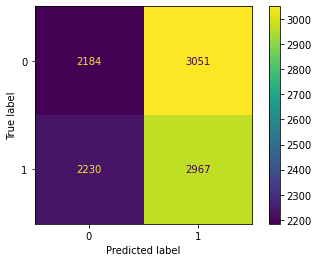

In [68]:

dtrain = X.copy()
dtrain = pd.DataFrame(dtrain)
dtrain['TARGET'] = 1
# dtrain = dtrain.drop(['id','label'], axis=1)

dtest = ntest.copy()
dtest = pd.DataFrame(dtest)

dtest['TARGET'] = 0
# dtest = dtest.drop(['id'], axis=1)
print(dtrain.shape, dtest.shape)
data = pd.concat(( dtrain, dtest ))

data = data.iloc[ np.random.permutation(len( data )) ]
# data.reset_index( drop = True, inplace = True )

from imblearn.over_sampling import SMOTE
ros = SMOTE(random_state=0)


x = data.drop( [ 'TARGET'], axis = 1 )
y = data.TARGET
x, y = ros.fit_resample(x, y)
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
e= LogisticRegression(random_state=0)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
xt, xtt, yt, ytt = train_test_split(x,y,test_size=0.6,random_state=0)
e.fit(xt,yt)
pred = e.predict(xtt)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ytt, pred), display_labels=e.classes_)
disp.plot()
plt.show()